# AXL RNAseq analysis

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from msresist.pre_processing import preprocessing, VarianceFilter
from msresist.clustering import MassSpecClustering
from msresist.plsr import plotR2YQ2Y
from msresist.figures.common import import_phenotype_data, formatPhenotypesForModeling
from sklearn.cross_decomposition import PLSRegression
import pandas as pd

In [3]:
# Set plotting format
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [4]:
eg = pd.read_csv("msresist/data/RNAseq/final-eigengenes.csv").set_index("Module")
memberships = pd.read_csv("msresist/data/RNAseq/final-membership.csv")

### Use MS data to predict Modules 

In [5]:
# Import siganling data
ms = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
ms = ms.rename(columns={"PC9 A":"WT", "KO A":"KO", "Kd A":"KDead", "KI A":"KI","M4 A": "Y634F", "M5 A":"Y643F", "M7 A":"Y698F", "M10 A":"Y726F", "M11 A":"Y750F", "M15 A":"Y821F"})
d = ms.select_dtypes(include=['float64']).T
i = ms.select_dtypes(include=['object'])

In [6]:
ddmc = MassSpecClustering(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=5).fit(d)
centers = pd.DataFrame(ddmc.transform())
centers.index = d.index

In [29]:
egEA = eg.loc[:, eg.columns.str.contains("EA")]
egEA.insert(1, "KO", eg["KOE"])
egEA = egEA.rename(columns={"WTEA":"WT", "KDeEA":"KDead", "KIEA":"KI", "M4EA": "Y634F", "M5EA":"Y643F", "M7EA":"Y698F", "M10EA":"Y726F", "M11EA":"Y750F", "M15EA":"Y821F"})
egEA = egEA[list(centers.index)].T

In [83]:
egEA_f = VarianceFilter(egEA.T, list(egEA.T.columns), axis=1, varCut=0.07).T

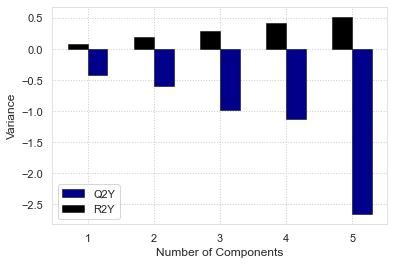

In [85]:
_, ax = plt.subplots(1, 1)
plotR2YQ2Y(ax, PLSRegression(n_components=2), centers, egEA_f, b=6, color="darkblue", title=False)

In [86]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.metrics import r2_score
reg = MultiTaskLassoCV(cv=10, eps=1e-5).fit(egEA_f, centers)
r2_score(centers, reg.predict(egEA_f))

0.3610565108543359

### Use Modules to predict Phenotypes

In [87]:
cv = import_phenotype_data(phenotype="Cell Viability")
red = import_phenotype_data(phenotype="Cell Death")
sw = import_phenotype_data(phenotype="Migration")
c = import_phenotype_data(phenotype="Island")
y = formatPhenotypesForModeling(cv, red, sw, c)
y = y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")

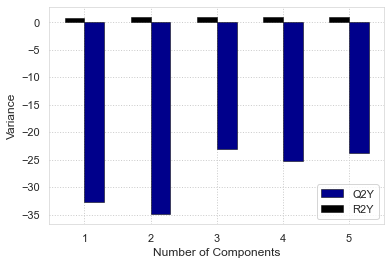

In [88]:
_, ax = plt.subplots(1, 1)
plotR2YQ2Y(ax, PLSRegression(n_components=2), egEA_f, y, b=6, color="darkblue", title=False)

In [80]:
reg = MultiTaskLassoCV(cv=10, eps=1e-5).fit(egEA_f, y)
r2_score(y, reg.predict(egEA_f))

0.3095208979628891